In [5]:
from fastai.conv_learner import *
from cv2 import resize
%matplotlib inline

In [2]:
class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [3]:
class FilterVisualizer():
    def __init__(self, size=56, octave_n=12, octave_scale=1.2):
        self.size, self.octave_n, self.octave_scale = size, octave_n, octave_scale
        self.model = vgg16(pre=True).cuda().eval()
        set_trainable(self.model, False)
        self.output = None

    def visualize(self, layer, filter, lr=0.1, steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255
        activations = SaveFeatures(list(self.model.children())[layer])

        for oct in range(self.octave_n):
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(steps):
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.octave_scale * sz)
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
            if blur is not None: img = cv2.blur(img,(blur,blur))
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

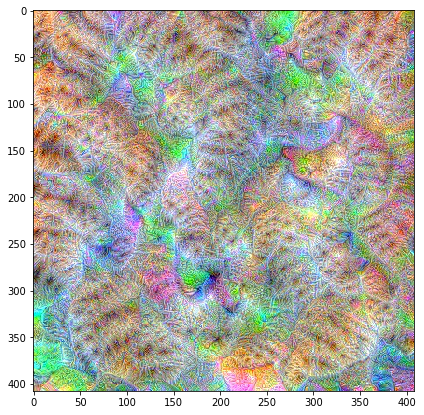

In [19]:
if __name__ == "__main__":
    layer = 40
    filter = 281
    
    FV = FilterVisualizer(56, 12, 1.2)
    FV.visualize(layer, filter, blur=5)
    
    img = PIL.Image.open("layer_"+str(layer)+"_filter_"+str(filter)+".jpg")
    plt.figure(figsize=(7,7))
    plt.imshow(img)